<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./10_sentinel5p_L2_retrieve.ipynb"><< 10 - Sentinel-5P Carbon Monoxide - Retrieve</a><span style="float:right;"><a href="./12_sentinel5p_L2_exercise.ipynb">12 - Sentinel-5P Carbon Monoxide - Exercise >></a></span>

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# Copernicus Sentinel-5 Precursor (Sentinel-5p) - Carbon Monoxide

The subsequent example introduces you to Sentinel-5p data in general and the total column of carbon monoxide sensed by Sentinel-5p in specific. Carbon Monoxide is a good trace gas in order to monitor and track fire occurences. The example is based on the Australian bushfires that severely affected Australias East Coast end of 2019 and beginning of 2020.


#### Module outline:
* [1 - Load and browse Sentinel-5P TROPOMI data](#load_s5p)
* [2 - Create a geographical subset](#geographical_subset)
* [3 - Visualize Sentinel-5P Carbon Monoxide data](#visualize_s5p)

#### Load required libraries

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import geopandas as gpd

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
from ipynb.fs.full.functions import visualize_pcolormesh, generate_geographical_subset

<hr>

## <a id="load_s5p"></a>Load and browse Sentinel-5P data

A Sentinel-5p file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5p variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5p data is disseminated in `netCDF`. You can load multiple `netCDF` files at once with the `open_mfdataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5p data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group
- `concat_dim='scanline'`: multiple files will be concatenated based on the scanline dimension
- `combine=nested`: combine a n-dimensional grids into one along each dimension of the grid

Let us load a Sentinel-5p data file as `xarray.Dataset` and inspect the data structure:

In [16]:
s5p = xr.open_mfdataset('./data/sentinel_5p/co/2019/12/29/*', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 8344, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2019-12-29
  * layer                                  (layer) float32 49500.0 ... 500.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
    latitude                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    longitude                              (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
Data variables:
    delta_time                             (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4172), meta=np.ndarray>
    time_utc                               (time, scanline)

You see that a Sentinel-5p data files contains of five dimensions and five data variables:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`

* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `ga_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `carbonmonoxide_total_column`: Vertically integrated CO column density
  * `carbonmonoxide_total_column_precision`: Standard error of the vertically integrate CO column

You can specify one variable of interest and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the atmosphere mole content of carbon monoxide, has the unit `mol per m-2`, and has three dimensions, `time`, `scanline` and `groundpixel` respectively.

In [4]:
s5p_co = s5p['carbonmonoxide_total_column']
s5p_co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 8344, ground_pixel: 215)>
dask.array<concatenate, shape=(1, 8344, 215), dtype=float32, chunksize=(1, 4172, 215)>
Coordinates:
  * time          (time) datetime64[ns] 2019-12-29
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
    latitude      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    longitude     (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6

You can do this for the available variables, but also for the dimensions latitude and longitude.

In [5]:
print('Latitude')
print(s5p_co.latitude)

print('Longitude')
print(s5p_co.longitude)

Latitude
<xarray.DataArray 'latitude' (time: 1, scanline: 8344, ground_pixel: 215)>
dask.array<concatenate, shape=(1, 8344, 215), dtype=float32, chunksize=(1, 4172, 215)>
Coordinates:
  * time          (time) datetime64[ns] 2019-12-29
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
    latitude      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
    longitude     (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 215), meta=np.ndarray>
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds
Longitude
<xarray.DataArray 'longitude' (time: 1, scanline: 8344, ground_pixel: 215)>
dask.array<concatenate, shape=(1, 8344, 215), dtype=float32, chunks

<br>

You can retrieve the array values of the variable with squared bracket: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [14]:
s5p_co_2912 = s5p_co[0,:,:]
s5p_co_2912

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 8344, ground_pixel: 215)>
dask.array<getitem, shape=(8344, 215), dtype=float32, chunksize=(4172, 215)>
Coordinates:
    time          datetime64[ns] 2019-12-29
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
    latitude      (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 215), meta=np.ndarray>
    longitude     (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 215), meta=np.ndarray>
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

The attributes of the data array hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from `mol per m2` to `molecules per cm2`.


In [15]:
conversion_factor = s5p_co_2912.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

Additionally, you can save the attribute `longname`, which you can make use of when visualizing the data.

In [16]:
longname = s5p_co.long_name
longname

'Vertically integrated CO column'

## <a id='geographical_subset'></a>Create  a geographical subset

You can zoom into a region by specifying a `bounding box` of interest. Let's set the extent to southeast Australia with the following bounding box information:

In [9]:
lonmin=130
lonmax=170
latmin=-50
latmax=-19

You can use the function [generate_geographical_subset()](./functions.ipynb#generate_geographical_subset) to subset an xarray DataArray based on a given bounding box.

In [17]:
s5p_co_subset = generate_geographical_subset(s5p_co_2912, latmin, latmax, lonmin, lonmax)
s5p_co_subset

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 1462, ground_pixel: 215)>
dask.array<where, shape=(1462, 215), dtype=float32, chunksize=(768, 215)>
Coordinates:
    time          datetime64[ns] 2019-12-29
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * scanline      (scanline) float64 1.523e+03 1.524e+03 ... 2.192e+03 2.193e+03
    latitude      (scanline, ground_pixel) float32 -52.41825 ... -14.701418
    longitude     (scanline, ground_pixel) float32 155.38629 ... 151.31766
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

## <a id="plotting_s5p"></a>Plotting example - Sentinel-5P data

You can plot data arrays of type `numpy` with matplotlib's `pcolormesh` function. In combination with the library [cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

In order to make it easier to visualize the Carbon Monoxide values, we apply the conversion factor to the DataArray. This converts the Carbon Monoxide values from mol per m<sup>2</sup> to molecules per cm<sup>2</sup>.

In [18]:
s5p_co_converted = s5p_co_subset*conversion_factor
s5p_co_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 1462, ground_pixel: 215)>
dask.array<mul, shape=(1462, 215), dtype=float32, chunksize=(768, 215)>
Coordinates:
    time          datetime64[ns] 2019-12-29
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * scanline      (scanline) float64 1.523e+03 1.524e+03 ... 2.192e+03 2.193e+03
    latitude      (scanline, ground_pixel) float32 -52.41825 ... -14.701418
    longitude     (scanline, ground_pixel) float32 155.38629 ... 151.31766

For visualization, you can use the function [visualize_pcolormesh](./functions#visualize_pcolormesh) to visualize the data. The following kwargs have to be defined:
* `xarray DataArray`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `longname`
* `vmin`, `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `log`
* `set_global`

Now, let us apply the [visualize_pcolormesh](./functions#visualize_pcolormesh) function and visualize the vertically integrated carbon monoxide column sensored from the Sentinel-5P satellite on 29 December 2019.

Note: Multiplying the DataArray values with 1e-18 improves the readibility of the map legend.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fba4aabc470>)

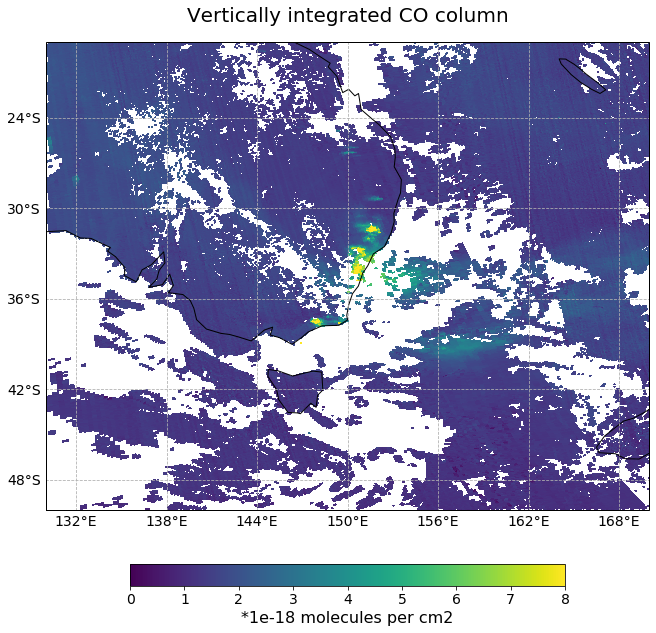

In [22]:
visualize_pcolormesh(s5p_co_converted*1e-18, 
                     s5p_co_converted.longitude, 
                     s5p_co_converted.latitude, 
                     ccrs.PlateCarree(), 
                     'viridis', 
                     '*1e-18 molecules per cm2', 
                     longname, 
                     0, 8, 
                     lonmin, lonmax, latmin, latmax, 
                     log=False, 
                     set_global=False)


<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./10_sentinel5p_L2_retrieve.ipynb"><< 10 - Sentinel-5P Carbon Monoxide - Retrieve</a><span style="float:right;"><a href="./12_sentinel5p_L2_exercise.ipynb">12 - Sentinel-5P Carbon Monoxide - Exercise >></a></span>

<hr>

<img src='./img/all_partners_wekeo.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>